# Multi-label Amazon From Space

In [1]:
#@title

! pip -qq install tensorflow-addons
! pip install -qq -U tensorflow_datasets

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

import tensorflow as tf
from autoaugment import ImageNetPolicy, CIFAR10Policy

for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    #tf.config.experimental.set_virtual_device_configuration(d,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.


In [2]:
if IS_COLAB:
  base_dir = '/content/drive/MyDrive'
  data_dir = '/root/tensorflow_datasets'
else:
  base_dir = './'
  data_dir = './datasets'


class Config:
  class data:
    path = f'{data_dir}/amazon-from-space'
    size = (256, 256)
    shape = (*size, 3)
    batch_size = 64
    shuffle_buffer_size = 8 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 2142
    shuffle = True

    valid_size = 0.3

    preprocess = tf.keras.applications.efficientnet.preprocess_input
    deprocess = lambda x: tf.cast(tf.clip_by_value(x, 0, 255), tf.uint8)

  class aug:
    auto_augmentation_policy = CIFAR10Policy()
    brightness_delta =  .2
    saturation_lower =  .2
    saturation_upper = 1.0
    contrast_lower   =  .5
    contrast_upper   = 1.5
    hue_delta        =  .0
    
  class model:
    pool_layer = 'avg_pool'
    backbone = tf.keras.applications.EfficientNetB3

    build_options = {
      'predictions': {
        'kernel_regularizer': tf.keras.regularizers.L2(0.01),
        # 'bias_regularizer': tf.keras.regularizers.L2(0.01),
        # 'activity_regularizer': tf.keras.regularizers.L2(0.01),
      }
    }
  
  class training:
    epochs = 80
    learning_rate = .1
    
    loss = tf.losses.BinaryCrossentropy(from_logits=True)
    optimizer = tf.optimizers.SGD(
      learning_rate=learning_rate,
      momentum=0.9,
      nesterov=True
    )

    logs    = f'{base_dir}/logs/amazon-from-space-mo444/eb3-ce-auto-aug-cifar10/'
    weights = f'{base_dir}/models/amazon-from-space-mo444/eb3-ce-auto-aug-cifar10.h5'

    callbacks = [
      tf.keras.callbacks.TerminateOnNaN(),
      tf.keras.callbacks.ModelCheckpoint(weights, save_best_only=True, save_weights_only=True, verbose=1),
      tf.keras.callbacks.TensorBoard(logs, profile_batch=0),
      tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.001, verbose=1),
      tf.keras.callbacks.EarlyStopping(patience=20, min_delta=0.01, verbose=1),
    ]

  class fine_tuning:
    epochs = 120
    learning_rate = .01

    loss = tf.losses.BinaryCrossentropy(from_logits=True)
    # loss = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True)
    optimizer = tf.optimizers.SGD(
      learning_rate=learning_rate,
      momentum=0.9,
      nesterov=True
    )

    logs    = f'{base_dir}/logs/amazon-from-space-mo444/eb3-ce-auto-aug-ft/'
    weights = f'{base_dir}/models/amazon-from-space-mo444/eb3-ce-auto-aug-ft.h5'

    callbacks = [
      tf.keras.callbacks.TerminateOnNaN(),
      tf.keras.callbacks.ModelCheckpoint(weights, save_best_only=True, save_weights_only=True, verbose=1),
      tf.keras.callbacks.TensorBoard(logs, profile_batch=0, histogram_freq=1),
      tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.0001, verbose=1),
      tf.keras.callbacks.EarlyStopping(patience=20, min_delta=0.01, verbose=1),
    ]

    unfreeze_layers = .6  # 60%
    frozen_bn = False

  class experiment:
    seed = 41248
    override = True

## Setup

In [3]:
import os
import shutil
from math import ceil

from typing import List, Optional

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tensorflow.keras import callbacks

In [4]:
for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.


In [5]:
R = tf.random.Generator.from_seed(Config.experiment.seed, alg='philox')
C = np.asarray(sns.color_palette("Set1", 21))
CMAP = sns.color_palette("Set1", 21, as_cmap=True)

sns.set_style("whitegrid", {'axes.grid' : False})

In [6]:
def opt_or_default(options):
  def _get_options(param):
    return options.get(param, {})
  
  return _get_options


def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x


def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    figsize=(16, 7.2),
    cmap=None
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

In [7]:
tf.keras.Model

tensorflow.python.keras.engine.training.Model

In [8]:
def unfreeze_top_layers(
    model: tf.keras.Model,
    layers: float,
    freeze_bn: bool
):
  if not layers:
    model.trainable = False
    return

  model.trainable = True

  frozen_layer_ix = int((1-layers) * len(model.layers))
  for ix, l in enumerate(model.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not freeze_bn))
  
  print(f'Unfreezing {layers:.0%} layers. Bottom-most is the {frozen_layer_ix}-nth layer ({model.layers[frozen_layer_ix].name}).')

## Dataset

In [9]:
#%%time
#%%bash

#  if [ ! -d /root/tensorflow_datasets/amazon-from-space/ ]; then
#    mkdir -p /root/tensorflow_datasets/amazon-from-space/

#    gdown --id 11DFKx6xQ2-I_zgZtvxUrCjq-50odGP5N --output /root/tensorflow_datasets/amazon-from-space/train-jpg.tfrecords
    # If the above is not working:
    # cp /content/drive/MyDrive/datasets/amazon-from-space/train-jpg.tfrecords \
    #    /root/tensorflow_datasets/amazon-from-space/
#  else
#    echo "Dir $data_path found. Skipping."
#  fi

In [10]:
class AmazonFromSpace:
    num_train_samples = 40479
    num_test_samples  = 61191

    classes_ = np.asarray(
        ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down',
         'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze',
         'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water'])

    @classmethod
    def int2str(cls, indices):
        return cls.classes_[indices]
    
    @staticmethod
    def _bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.tobytes()]))

    @staticmethod
    def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
    @staticmethod
    def decode_fn(record_bytes):
        r = tf.io.parse_single_example(record_bytes, {
          'filename': tf.io.FixedLenFeature([], tf.string),
          'image': tf.io.FixedLenFeature([], tf.string),
          'height': tf.io.FixedLenFeature([], tf.int64, default_value=[256]),
          'width': tf.io.FixedLenFeature([], tf.int64, default_value=[256]),
          'channels': tf.io.FixedLenFeature([], tf.int64, default_value=[3]),
          'label': tf.io.VarLenFeature(tf.int64),
        })
        
        r['image'] = tf.reshape(tf.io.decode_raw(r['image'], tf.uint8),
                                (r['height'], r['width'], r['channels']))
        r['label'] = tf.sparse.to_dense(r['label'])

        return r
    
    @classmethod
    def load(cls, tfrecords_path):
        return tf.data.TFRecordDataset(tfrecords_path).map(cls.decode_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
CLASSES = AmazonFromSpace.classes_
int2str = AmazonFromSpace.int2str
num_samples = AmazonFromSpace.num_train_samples
num_train_samples = int((1-Config.data.valid_size)*num_samples)
num_valid_samples = int(Config.data.valid_size*num_samples)

In [12]:
from functools import partial


@tf.function
def load_fn(d, augment=False):
  image = d['image']
  labels = d['label']

  image = tf.cast(image, tf.float32)
  image = tf.ensure_shape(image, Config.data.shape)
  image = (tf.numpy_function(auto_augment_fn, [image], tf.uint8)
           if augment
           else default_policy_fn(image))
  #image = tf.ensure_shape(image, Config.data.shape)
  if augment:
    image = tf.ensure_shape(image, (5, *Config.data.shape))
  else:
    image = tf.ensure_shape(image, Config.data.shape)

  #image = (augment_policy_fn(image)
  #         if augment
  #         else default_policy_fn(image))
  
  image = Config.data.preprocess(image)

  if augment:
    return image, tf.reshape(tf.tile(labels_to_one_hot(labels), [5]), (5, 17))
  else:
    return image, labels_to_one_hot(labels)


def labels_to_one_hot(labels):
  return tf.reduce_max(
      tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0)


def prepare(ds, batch_size, cache=False, shuffle=False, augment=False):
  if cache: ds = ds.cache()
  if shuffle: ds = ds.shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed)

  if augment:
    return (ds.map(partial(load_fn, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
              .unbatch()
              .shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed + 1)
              .batch(batch_size, drop_remainder=True)
              .prefetch(Config.data.prefetch_buffer_size))
  else:
    return (ds.map(partial(load_fn, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
              .batch(batch_size, drop_remainder=True)
              .prefetch(Config.data.prefetch_buffer_size))

In [13]:
def default_policy_fn(image):
  return image

def auto_augment_fn(image):
  #image = Image.fromarray(np.uint8(image))
  #image = Config.aug.auto_augmentation_policy(image)
  #image = np.asarray(image)
  image = Image.fromarray(np.uint8(image))
  #(8, 256, 256, 3)
  images = [np.asarray(Config.aug.auto_augmentation_policy(image)) for _ in range(4)]
  images.append(np.asarray(image))

  return np.asarray(images)


def augment_policy_fn(image):
  seeds = R.make_seeds(6)

  image = tf.image.stateless_random_flip_left_right(image, seed=seeds[:, 0])
  image = tf.image.stateless_random_flip_up_down(image, seed=seeds[:, 1])
  image = tf.image.stateless_random_hue(image, Config.aug.hue_delta, seed=seeds[:, 2])
  image = tf.image.stateless_random_brightness(image, Config.aug.brightness_delta, seed=seeds[:, 3])
  image = tf.image.stateless_random_contrast(image, Config.aug.contrast_lower, Config.aug.contrast_upper, seed=seeds[:, 4])
  image = tf.image.stateless_random_saturation(image, Config.aug.saturation_lower, Config.aug.saturation_upper, seed=seeds[:, 5])

  return image

In [14]:
train_dataset = AmazonFromSpace.load(f'{data_dir}/amazon-from-space/train-jpg.tfrecords')
valid_dataset = train_dataset.take(num_valid_samples)
train_dataset = train_dataset.skip(num_valid_samples)

train = prepare(train_dataset, Config.data.batch_size, shuffle=True, augment=True)
valid = prepare(valid_dataset, Config.data.batch_size)

In [15]:
#@title

for stage, batches, samples in zip(('training', 'validation', 'testing'),
                                   (train, valid),
                                   (AmazonFromSpace.num_train_samples,
                                    num_valid_samples,
                                    AmazonFromSpace.num_test_samples)):
  print(stage)
  print(f'  {batches}')
  print(f'  samples: {samples}')
  print(f'  steps  : {samples // Config.data.batch_size}')
  print()

training
  <PrefetchDataset shapes: ((64, 256, 256, 3), (64, 17)), types: (tf.uint8, tf.float32)>
  samples: 40479
  steps  : 632

validation
  <PrefetchDataset shapes: ((64, 256, 256, 3), (64, 17)), types: (tf.float32, tf.float32)>
  samples: 12143
  steps  : 189



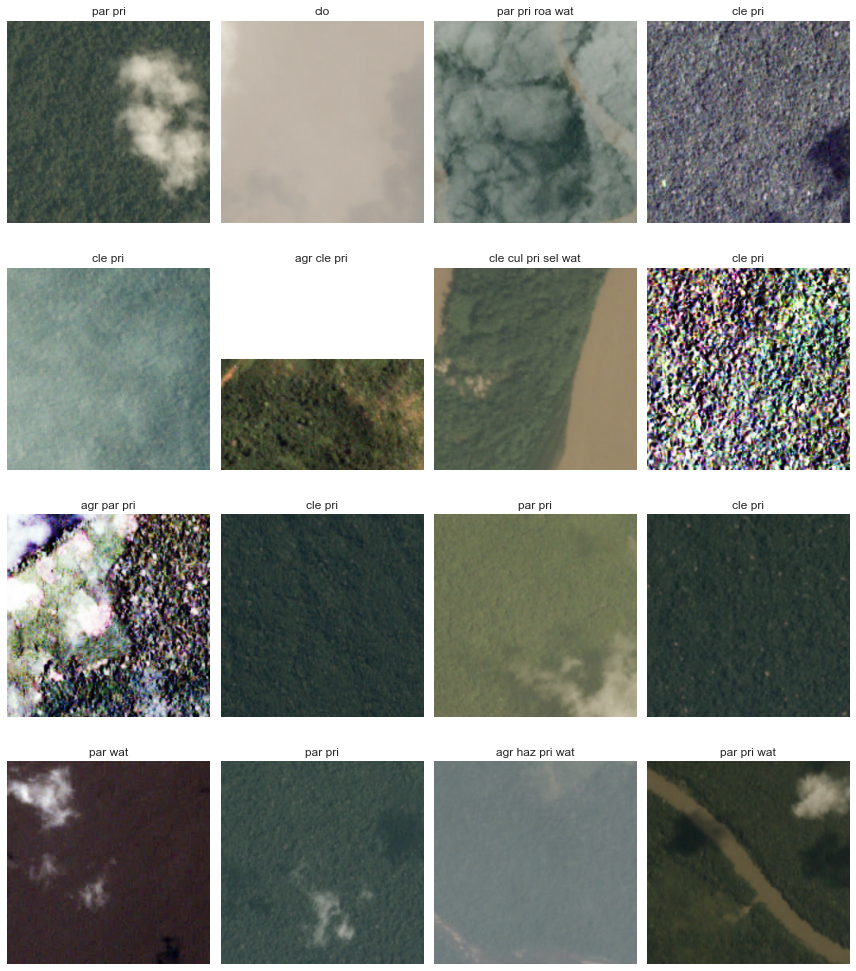

In [16]:
#@title

from pathlib import Path

for images, labels in train.take(1):
  gt = [' '.join((e[:3] for e in CLASSES[l].astype(str))) for l in labels.numpy().astype(bool)]
  visualize(Config.data.deprocess(images[:16]), gt, rows=4, figsize=(12, 14));

## Network

### Backbone

In [17]:
print(f'Loading {Config.model.backbone.__name__}')

backbone = Config.model.backbone(
  classifier_activation=None,
  include_top=False,
  input_shape=Config.data.shape
)

Loading EfficientNetB3


### Classification Head

In [18]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Dropout, Dense


def build_classifier(opts):
  opts = opt_or_default(opts)

  x = tf.keras.Input(Config.data.shape, name='images')
  y = backbone(x)
  y = GlobalAveragePooling2D(name=Config.model.pool_layer)(y)
  y = Dense(len(CLASSES), name='predictions', **opts('predictions'))(y)

  return tf.keras.Model(
    inputs=x,
    outputs=y,
    name=f'clf_{Config.model.backbone.__name__}_voc12')

In [19]:
nn = build_classifier(Config.model.build_options)

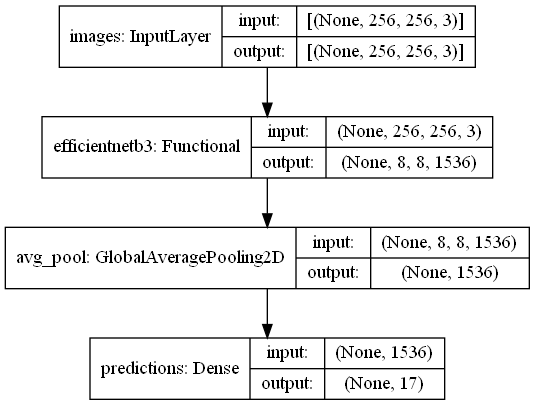

In [20]:
tf.keras.utils.plot_model(nn, show_shapes=True)

## Metrics

In [21]:
# Fix for tensorflow metrics that do not support
# sigmoid_crossentropy_with_logits, for some reason...

class FromLogitsMixin:
  def __init__(self, from_logits=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.from_logits = from_logits

  def update_state(self, y_true, y_pred, sample_weight=None):
    if self.from_logits:
      y_pred = tf.nn.sigmoid(y_pred)
    return super().update_state(y_true, y_pred, sample_weight)

In [22]:
class AUC(FromLogitsMixin, tf.metrics.AUC):
  ...

class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
  ...

class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
  ...

class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
  ...

class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
  ...

class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
  ...

class Precision(FromLogitsMixin, tf.metrics.Precision):
  ...

class Recall(FromLogitsMixin, tf.metrics.Recall):
  ...

class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
  ...

class MultiLabelConfusionMatrix(FromLogitsMixin, tfa.metrics.MultiLabelConfusionMatrix):
  ...

## Training

In [23]:
def train_fn(
    epochs: int = 80,
    initial_epoch: int = 0,
    callbacks: Optional[List[tf.keras.callbacks.Callback]] = None,
    steps_per_epoch: Optional[int] = None,
    validation_steps: Optional[int] = None,

    logs: str = None,
    weights: str = None,
):
  try:
    if logs and os.path.exists(logs) and initial_epoch == 0:
      if not Config.experiment.override:
        raise ValueError(f'A training was found in {logs}. '
                         f'Either move it or set experiment.override to True.')

      print(f'Overriding previous training at {logs}.')
      shutil.rmtree(logs)
    
    if weights: os.makedirs(os.path.dirname(weights), exist_ok=True)

    nn.fit(
      train.repeat(),
      validation_data=valid.repeat(),
      epochs=epochs,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      initial_epoch=initial_epoch,
      callbacks=callbacks);

  except KeyboardInterrupt: print('\ninterrupted')
  else: print('\ndone')

### Top Classifier Training

In [24]:
backbone.trainable = False

In [25]:
nn.compile(
    optimizer=Config.training.optimizer,
    loss=Config.training.loss,
    metrics=[
      Precision(from_logits=True),
      Recall(from_logits=True),
      F1Score(num_classes=len(CLASSES), from_logits=True, average='macro'),
      MultiLabelConfusionMatrix(num_classes=len(CLASSES), from_logits=True),
      tf.metrics.AUC(multi_label=True, from_logits=True),
    ])

In [26]:
train_fn(
  epochs=Config.training.epochs,
  steps_per_epoch=num_train_samples*5 // Config.data.batch_size, # Multiplicar num_train_samples pelo número de novas imagens geradas (Ex. 8)
  validation_steps=num_valid_samples // Config.data.batch_size,
  callbacks=Config.training.callbacks,
  logs=Config.training.logs,
  weights=Config.training.weights,
)

c:\users\rodri\.conda\envs\mo443\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/80
2213/2213 [==============================] - ETA: 0s - loss: 0.2184 - precision: 0.8691 - recall: 0.7116 - f1_score: 0.0628 - Multilabel_confusion_matrix: 35408.0000 - auc: 0.7815

c:\users\rodri\.conda\envs\mo443\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '
c:\users\rodri\.conda\envs\mo443\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric MultiLabelConfusionMatrix implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


2213/2213 [==============================] - 254s 108ms/step - loss: 0.2184 - precision: 0.8691 - recall: 0.7116 - f1_score: 0.0628 - Multilabel_confusion_matrix: 35408.0000 - auc: 0.7815 - val_loss: 0.1942 - val_precision: 0.8743 - val_recall: 0.6985 - val_f1_score: 0.0575 - val_Multilabel_confusion_matrix: 3024.0000 - val_auc: 0.8067

Epoch 00001: val_loss improved from inf to 0.19416, saving model to .//models/amazon-from-space-mo444\eb3-ce-auto-aug-cifar10.h5
Epoch 2/80
2213/2213 [==============================] - 237s 106ms/step - loss: 0.1991 - precision: 0.8727 - recall: 0.7087 - f1_score: 0.0590 - Multilabel_confusion_matrix: 35408.0000 - auc: 0.8146 - val_loss: 0.1921 - val_precision: 0.8859 - val_recall: 0.6899 - val_f1_score: 0.0567 - val_Multilabel_confusion_matrix: 3024.0000 - val_auc: 0.8215

Epoch 00002: val_loss improved from 0.19416 to 0.19210, saving model to .//models/amazon-from-space-mo444\eb3-ce-auto-aug-cifar10.h5
Epoch 3/80
2213/2213 [===========================

### Fine-Tuning

In [27]:
trained_epochs = 1

backbone.trainable = False
nn.load_weights(Config.training.weights)

In [28]:
unfreeze_top_layers(
  backbone,
  Config.fine_tuning.unfreeze_layers,
  Config.fine_tuning.frozen_bn
)

nn.compile(
  optimizer=Config.fine_tuning.optimizer,
  loss=Config.fine_tuning.loss,
  metrics=[
    Precision(from_logits=True),
    Recall(from_logits=True),
    F1Score(num_classes=len(CLASSES), from_logits=True, average='macro'),
    MultiLabelConfusionMatrix(num_classes=len(CLASSES), from_logits=True),
    tf.metrics.AUC(multi_label=True, from_logits=True),
  ])

Unfreezing 60% layers. Bottom-most is the 153-nth layer (block4c_se_reshape).


In [29]:
train_fn(
  epochs=Config.fine_tuning.epochs,
  initial_epoch=trained_epochs,
  steps_per_epoch=num_train_samples // Config.data.batch_size,
  validation_steps=num_valid_samples // Config.data.batch_size,
  callbacks=Config.fine_tuning.callbacks,
  logs=Config.fine_tuning.logs,
  weights=Config.fine_tuning.weights,
)

Epoch 2/120
442/442 [==============================] - 115s 238ms/step - loss: 0.2085 - precision_1: 0.8756 - recall_1: 0.7069 - f1_score: 0.0724 - Multilabel_confusion_matrix: 7072.0000 - auc_1: 0.7637 - val_loss: 0.1676 - val_precision_1: 0.9013 - val_recall_1: 0.7754 - val_f1_score: 0.1400 - val_Multilabel_confusion_matrix: 3024.0000 - val_auc_1: 0.8112

Epoch 00002: val_loss improved from inf to 0.16761, saving model to .//models/amazon-from-space-mo444\eb3-ce-auto-aug-ft.h5
Epoch 3/120
442/442 [==============================] - 101s 230ms/step - loss: 0.1703 - precision_1: 0.9006 - recall_1: 0.7606 - f1_score: 0.1172 - Multilabel_confusion_matrix: 7072.0000 - auc_1: 0.8019 - val_loss: 0.1485 - val_precision_1: 0.9069 - val_recall_1: 0.8061 - val_f1_score: 0.1488 - val_Multilabel_confusion_matrix: 3024.0000 - val_auc_1: 0.8406

Epoch 00003: val_loss improved from 0.16761 to 0.14846, saving model to .//models/amazon-from-space-mo444\eb3-ce-auto-aug-ft.h5
Epoch 4/120
442/442 [=======

## Evaluation

In [30]:
#@title


def labels_and_probs(nn, dataset):
  labels_ = []
  probs_ = []

  for i, (images, labels) in enumerate(dataset):
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(labels)
    probs_.append(y)

    print('.', end='' if i % 80 else '\n')
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))


def evaluate(l, p):
  acc, tpr, fpr, tnr, fnr, auc, mcm = metrics_per_label(l, p)

  return pd.DataFrame({
    'accuracy': acc,
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'roc auc score': auc,
    'support': tf.cast(tf.reduce_sum(l, axis=0), tf.int32),
    'label': CLASSES
  })

unfreeze_top_layers(
  backbone,
  Config.fine_tuning.unfreeze_layers,
  Config.fine_tuning.frozen_bn
)

nn.load_weights(Config.fine_tuning.weights)

In [31]:
l, p = labels_and_probs(nn, valid)

.
................................................................................
................................................................................
............................

In [32]:
from sklearn import metrics as skmetrics

def metrics_per_label(gt, probs, threshold=0.5):
  p_pred = tf.cast(probs > threshold, probs.dtype).numpy()

  tru_ = tf.reduce_sum(gt, axis=0)
  neg_ = tf.reduce_sum(1- gt, axis=0)

  tpr = tf.reduce_sum(p_pred*gt, axis=0) / tru_
  fpr = tf.reduce_sum(p_pred*(1-gt), axis=0) / neg_
  tnr = tf.reduce_sum((1-p_pred)*(1-gt), axis=0) / neg_
  fnr = tf.reduce_sum((1-p_pred)*gt, axis=0) / tru_

  f2_score = skmetrics.fbeta_score(gt, p_pred, beta=2, average=None)
  precision, recall, f1_score, support = skmetrics.precision_recall_fscore_support(
    gt, p_pred, average=None)

  mcm = skmetrics.multilabel_confusion_matrix(gt, p_pred)

  skmetrics.accuracy_score(gt, p_pred)

  return pd.DataFrame({
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'precision': precision,
    'recall': recall,
    'auc_score': skmetrics.roc_auc_score(gt, probs, average=None),
    'f1_score': f1_score,
    'f2_score': f2_score,
    'support': support,
    'label': CLASSES
  }), mcm

test_report, test_mcm = metrics_per_label(l, p)

c:\users\rodri\.conda\envs\mo443\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
test_report.round(4)

,true positive r,true negative r,false positive r,false negative r,precision,recall,auc_score,f1_score,f2_score,support,label
0,0.8490,0.9262,0.0738,0.1510,0.8350,0.8490,0.9634,0.8420,0.8462,3696,agriculture
1,0.8058,0.9986,0.0014,0.1942,0.8300,0.8058,0.9974,0.8177,0.8105,103,artisinal_mine
2,0.1084,0.9983,0.0017,0.8916,0.5745,0.1084,0.9135,0.1824,0.1294,249,bare_ground
3,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.8443,0.0000,0.0000,101,blooming
4,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.7604,0.0000,0.0000,40,blow_down
5,0.9743,0.9042,0.0958,0.0257,0.9597,0.9743,0.9896,0.9669,0.9713,8473,clear
6,0.8919,0.9872,0.0128,0.1081,0.8005,0.8919,0.9953,0.8438,0.8720,657,cloudy
7,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.9633,0.0000,0.0000,22,conventional_mine
8,0.3936,0.9847,0.0153,0.6064,0.7570,0.3936,0.9216,0.5179,0.4354,1306,cultivation
9,0.5260,0.9921,0.0079,0.4740,0.8707,0.5260,0.9609,0.6558,0.5713,1114,habitation


In [34]:
d = tf.cast(p > 0.5, tf.float32)
co_occurrence = tf.transpose(d) @ d
occurrence = tf.reshape(np.diag(co_occurrence), (-1, 1))

co_occurrence_rate = tf.math.divide_no_nan(co_occurrence, occurrence)

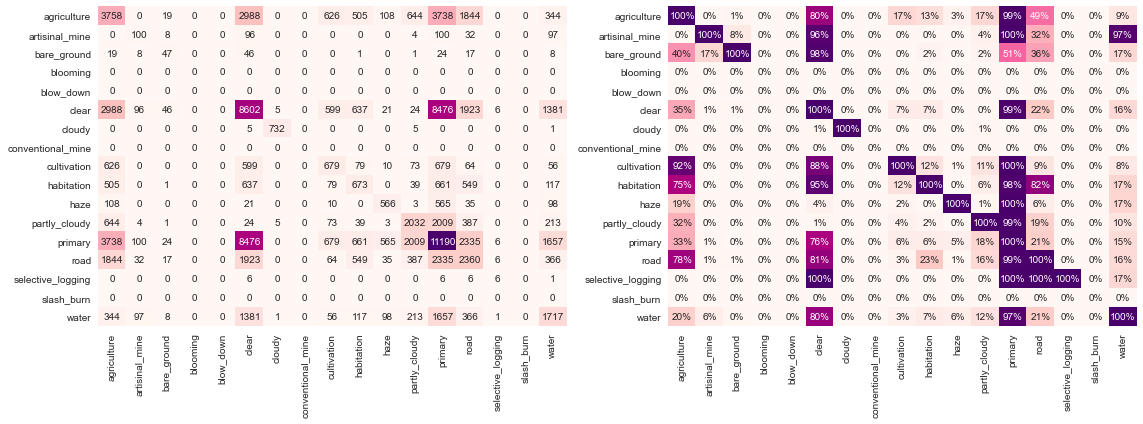

In [35]:
#@title Predictions Relation Matrix

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(
  co_occurrence.numpy().astype(int),
  annot=True,
  fmt='d',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)

plt.subplot(122)
sns.heatmap(
  co_occurrence_rate.numpy(),
  annot=True,
  fmt='.0%',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)
plt.tight_layout();

## Generate Answers

In [36]:
#%%bash

#if [ ! -f /root/tensorflow_datasets/amazon-from-space/test-jpg.tfrecords ]; then
#  mkdir -p /root/tensorflow_datasets/amazon-from-space/
#  gdown --id 1M0S88-D1J59kHPr2vG3hpFaS7n8fOsRC --output /root/tensorflow_datasets/amazon-from-space/test-jpg.tfrecords
  # cp /content/drive/MyDrive/datasets/amazon-from-space/test-jpg.tfrecords \
  #   /root/tensorflow_datasets/amazon-from-space/
#fi

In [37]:
test_dataset = AmazonFromSpace.load(f'{data_dir}/amazon-from-space/test-jpg.tfrecords')

In [38]:
test = (
  test_dataset
  .map(lambda item: (item['filename'], load_fn(item)[0]), num_parallel_calls=tf.data.AUTOTUNE)
  .batch(64)
  .prefetch(Config.data.prefetch_buffer_size))

In [39]:
def filenames_and_probs(nn, dataset):
  labels_ = []
  probs_ = []

  for ix, (files, images) in enumerate(dataset):
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(files)
    probs_.append(y)

    print('.', end='' if ix % 200 else '\n')
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))

In [40]:
files, preds = filenames_and_probs(nn, test)

.
........................................................................................................................................................................................................
........................................................................................................................................................................................................
........................................................................................................................................................................................................
........................................................................................................................................................................................................
............................................................................................................................................................

In [41]:
detection_threshold = 0.5

answer = pd.DataFrame({
  'image_name': files.numpy().astype(str),
  'tags': [' '.join(AmazonFromSpace.int2str(p)) for p in (preds > detection_threshold).numpy()]
})
answer['image_name'] = answer.image_name.str.split('.').str[0]

answer.to_csv(os.path.join(Config.fine_tuning.logs, 'test_answer.csv'), index=False)
answer.head()

,image_name,tags
0,test_17823,clear primary
1,test_29423,agriculture clear primary road
2,file_7472,agriculture clear cultivation primary
3,file_11084,clear primary
4,file_16408,agriculture clear primary road
